In [2]:
import pandas as pd
import tensorflow as tf
import numpy as np

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
df = pd.read_csv('/content/drive/MyDrive/Project DS/Toxic Comment Classification Challenge/train.csv')

In [6]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [7]:
df.iloc[7]['comment_text']

"Your vandalism to the Matt Shirvington article has been reverted.  Please don't do it again, or you will be banned."

In [8]:
df[df.columns[2:]].iloc[7]

toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
Name: 7, dtype: int64

# 1. Preprocessing

In [10]:
from tensorflow.keras.layers import TextVectorization

In [11]:
X = df['comment_text']
y = df[df.columns[2:]].values #transform to vector

In [12]:
MAX_WORDS = 200000 #number of words in the vocab

In [13]:
vectorizer = TextVectorization(max_tokens = MAX_WORDS,
                              output_sequence_length = 1800,
                              output_mode = 'int')

In [14]:
vectorizer.adapt(X.values)

In [15]:
vectorizer.get_vocabulary()

['',
 '[UNK]',
 'the',
 'to',
 'of',
 'and',
 'a',
 'you',
 'i',
 'is',
 'that',
 'in',
 'it',
 'for',
 'this',
 'not',
 'on',
 'be',
 'as',
 'have',
 'are',
 'your',
 'with',
 'if',
 'article',
 'was',
 'or',
 'but',
 'page',
 'my',
 'an',
 'from',
 'by',
 'do',
 'at',
 'about',
 'me',
 'so',
 'wikipedia',
 'can',
 'what',
 'there',
 'all',
 'has',
 'will',
 'talk',
 'please',
 'would',
 'its',
 'no',
 'one',
 'just',
 'like',
 'they',
 'he',
 'dont',
 'which',
 'any',
 'been',
 'should',
 'more',
 'we',
 'some',
 'other',
 'who',
 'see',
 'here',
 'also',
 'his',
 'think',
 'im',
 'because',
 'know',
 'how',
 'am',
 'people',
 'why',
 'edit',
 'articles',
 'only',
 'out',
 'up',
 'when',
 'were',
 'use',
 'then',
 'may',
 'time',
 'did',
 'them',
 'now',
 'being',
 'their',
 'than',
 'thanks',
 'even',
 'get',
 'make',
 'good',
 'had',
 'very',
 'information',
 'does',
 'could',
 'well',
 'want',
 'such',
 'sources',
 'way',
 'name',
 'these',
 'deletion',
 'pages',
 'first',
 'help'

In [16]:
vectorized_text = vectorizer(X.values) #Tokenize the words

In [17]:
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8) #helps prevent bottlenecks

In [18]:
batch_X, batch_y= dataset.as_numpy_iterator().next()

In [19]:
print('batch_X:', batch_X.shape)
print('batch_y:', batch_y.shape)

batch_X: (16, 1800)
batch_y: (16, 6)


In [20]:
train = dataset.take(int(len(dataset)*.7)) #take 70% length of the dataset
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

In [21]:
print('train:', len(train))
print('val:', len(val))
print('test:', len(test))

train: 6981
val: 1994
test: 997


In [22]:
train_generator = train.as_numpy_iterator()

In [23]:
train_generator.next()

(array([[   8,  202, 4500, ...,    0,    0,    0],
        [   1, 9616,   40, ...,    0,    0,    0],
        [ 482,  568,   35, ...,    0,    0,    0],
        ...,
        [ 205,   48,  361, ...,    0,    0,    0],
        [1048, 1058,  179, ...,    0,    0,    0],
        [  49, 3340,  224, ...,    0,    0,    0]]),
 array([[0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0]]))

# 2. Create Sequential Model

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [25]:
model = Sequential()

#create the embedding layer
model.add(Embedding(MAX_WORDS+1, 32))
#Bidirectional LSTM layer
model.add(Bidirectional(LSTM(32, activation='tanh')))
#Feature extrator fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
# Final layer
model.add(Dense(6, activation='sigmoid'))

In [26]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam')

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          6400032   
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                        

In [28]:
#history = model.fit(train, epochs=1, validation_data=val)

In [29]:
history = model.fit(train, epochs=10, validation_data=val)

Epoch 1/10
6981/6981 [==============================] - 736s 104ms/step - loss: 0.0622 - val_loss: 0.0463
Epoch 2/10
6981/6981 [==============================] - 605s 87ms/step - loss: 0.0458 - val_loss: 0.0418
Epoch 3/10
6981/6981 [==============================] - 597s 85ms/step - loss: 0.0405 - val_loss: 0.0369
Epoch 4/10
6981/6981 [==============================] - 622s 89ms/step - loss: 0.0364 - val_loss: 0.0325
Epoch 5/10
6981/6981 [==============================] - 608s 87ms/step - loss: 0.0328 - val_loss: 0.0291
Epoch 6/10
6981/6981 [==============================] - 612s 88ms/step - loss: 0.0297 - val_loss: 0.0264
Epoch 7/10
6981/6981 [==============================] - 603s 86ms/step - loss: 0.0266 - val_loss: 0.0236
Epoch 8/10
6981/6981 [==============================] - 595s 85ms/step - loss: 0.0240 - val_loss: 0.0202
Epoch 9/10
6981/6981 [==============================] - 607s 87ms/step - loss: 0.0211 - val_loss: 0.0187
Epoch 10/10
6981/6981 [==============================]

<Figure size 800x500 with 0 Axes>

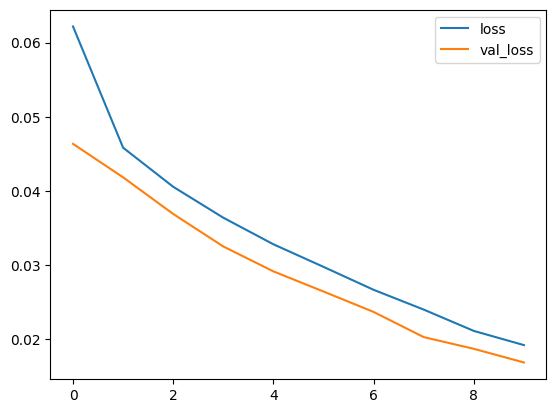

In [30]:
from matplotlib import pyplot as plt

plt.figure(figsize=(8, 5))
pd.DataFrame(history.history).plot()
plt.show()

# 3. Predictions

In [31]:
input_text = vectorizer('Shut up!')

In [32]:
batch = test.as_numpy_iterator().next()

In [33]:
batch_X, batch_y = test.as_numpy_iterator().next()

In [34]:
res = model.predict(np.expand_dims(input_text,0))

1/1 [==============================] - 1s 729ms/step


In [35]:
res

array([[4.6109909e-01, 3.4124497e-03, 5.6461221e-01, 5.0814269e-04,
        4.3684725e-02, 1.1465597e-03]], dtype=float32)

# 4. Evaluate Model

In [36]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [37]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [38]:
for batch in test.as_numpy_iterator():
    #Unpack the batch
    X_true, y_true = batch
    #Make a prediction
    yhat = model.predict(X_true)
    
    #Flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()
    
    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

1/1 [==============================] - 0s 70ms/step


In [39]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision: 0.9131165742874146, Recall:0.93459552526474, Accuracy:0.476429283618927


# 5. Test and Gradio

In [40]:
#!pip install gradio jinja2

In [43]:
!pip install gradio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.9/19.9 MB 75.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 77.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 8.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.1/288.1 kB 38.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 31.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.2/137.2 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 

In [45]:
import tensorflow as tf
import gradio as gr

In [46]:
model.save('toxicity.h5')

In [48]:
model = tf.keras.models.load_model('toxicity.h5')

In [49]:
input_text = vectorizer('Shut up!')

In [50]:
res = model.predict(np.expand_dims(input_text,0))

1/1 [==============================] - 1s 1s/step


In [51]:
res

array([[4.6109909e-01, 3.4124497e-03, 5.6461221e-01, 5.0814269e-04,
        4.3684725e-02, 1.1465597e-03]], dtype=float32)

In [52]:
def score_comment(comment):
    vectorized_comment = vectorizer([comment])
    results = model.predict(vectorized_comment)
    
    text = ''
    for idx, col in enumerate(df.columns[2:]):
        text += '{}: {}\n'.format(col, results[0][idx]>0.5)
    
    return text

In [54]:
interface = gr.Interface(fn=score_comment,
                        inputs=gr.inputs.Textbox(lines=2, placeholder='Comment to Score'),
                        outputs='text')

/usr/local/lib/python3.10/dist-packages/gradio/inputs.py:27: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gradio/inputs.py:30: UserWarning: `optional` parameter is deprecated, and it has no effect
  super().__init__(
/usr/local/lib/python3.10/dist-packages/gradio/inputs.py:30: UserWarning: `numeric` parameter is deprecated, and it has no effect
  super().__init__(


In [55]:
interface.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://e947cf632ff928bccd.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces
